# Import Data
Source: https://github.com/BCI-I/BCII-IDUN-Challenge-tutorials/blob/main/01_data_preparation.ipynb

In [37]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import scipy
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import balanced_accuracy_score, f1_score


from utils import load_eeg, load_labels, plot_eeg, get_event_epochs, markers


In [38]:
# check current working directory
print(Path.cwd())

# data_dir = Path("~/Data/bci-i-idun-eeg-analysis-challenge")
data_dir = Path("~/Data").expanduser() / "bci-i-idun-eeg-analysis-challenge"
data_dir.exists()

# load the data
SUBJECT = "S001"  # [S001-3 are in the training set, S004 is in the test set]

/Users/jantinebroek/Projects/kaggle/bci_eeg


In [39]:
# load the EEG data
eeg = load_eeg(data_dir, SUBJECT)

Creating RawArray with float64 data, n_channels=1, n_times=5394412
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>


In [40]:
## ANY PREPROCESSING STEPS APPLIED TO EEG SHOULD HAPPEN HERE


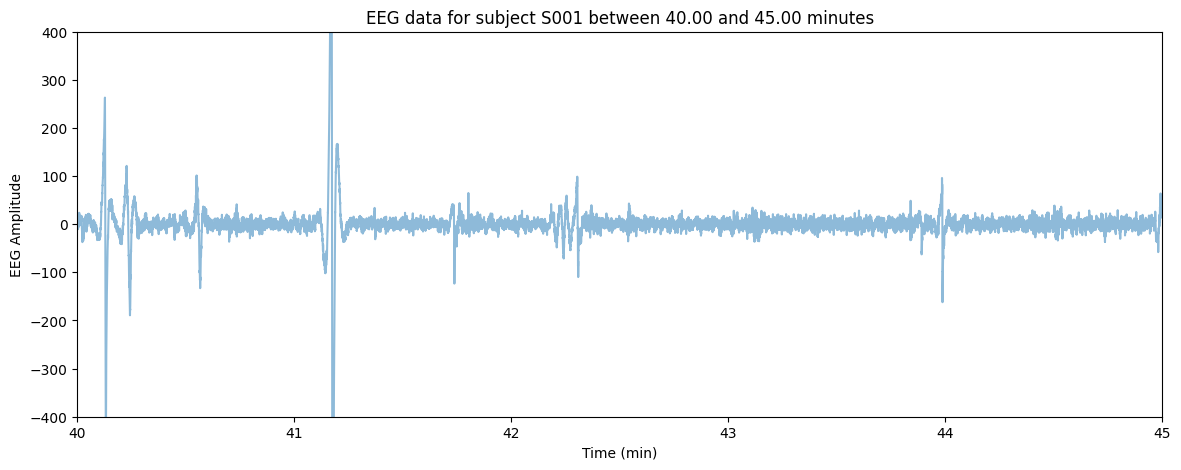

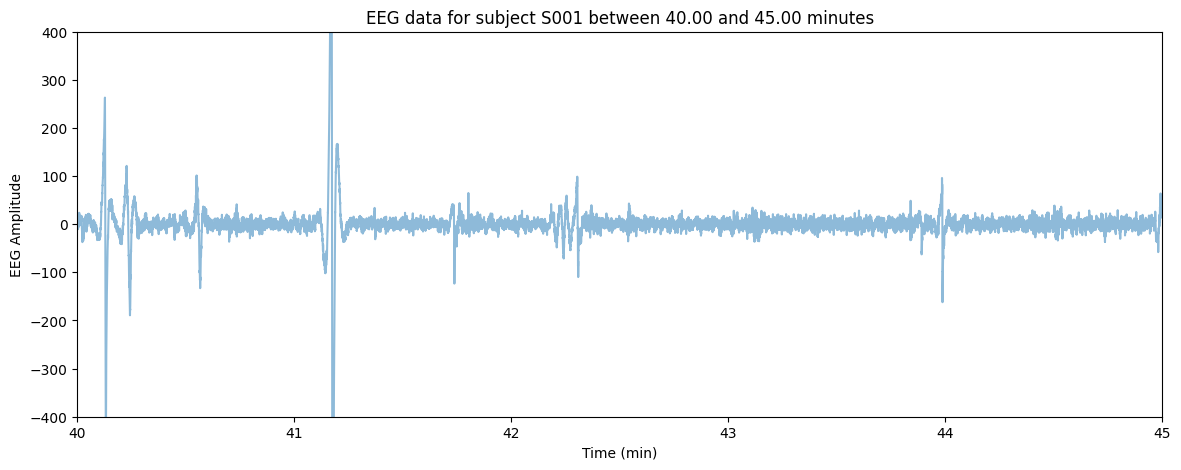

In [41]:
# this function plots the EEG data. You can pass a start/end time in minutes to zoom in on a particular time window
plot_eeg(eeg, SUBJECT, 40, 45)[0]

In [42]:
# load the labels
labels = load_labels(data_dir, SUBJECT)
labels.head()

,Marker,Timestamp_samples,Epoch
0,REM,38643,6
1,REM,39196,6
2,REM,39404,6
3,REM,40046,6
4,REM,40725,6


In [43]:
# Labels are not balanced

print("\nCounts of each marker:")
print(labels.Marker.value_counts())


Counts of each marker:
S       210
K       199
REM     170
Son      29
A        22
Soff     18
MS        7
Name: Marker, dtype: int64


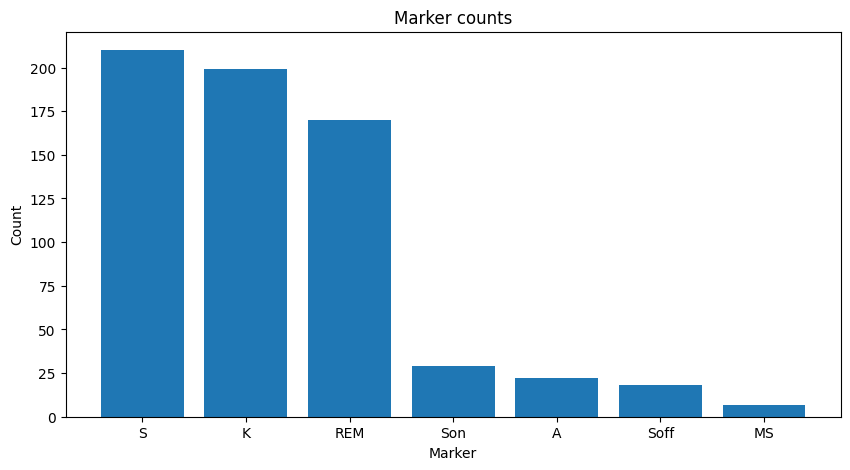

In [44]:
f, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels.Marker.value_counts().index, labels.Marker.value_counts().values)
ax.set(title="Marker counts", xlabel="Marker", ylabel="Count")
plt.show()

Later, when we train models we will see the effect of this inbalance. For now, we can overlay the labels timestamps over the EEG data to get an idea of the timing of each event and what the signal looks like around each event.

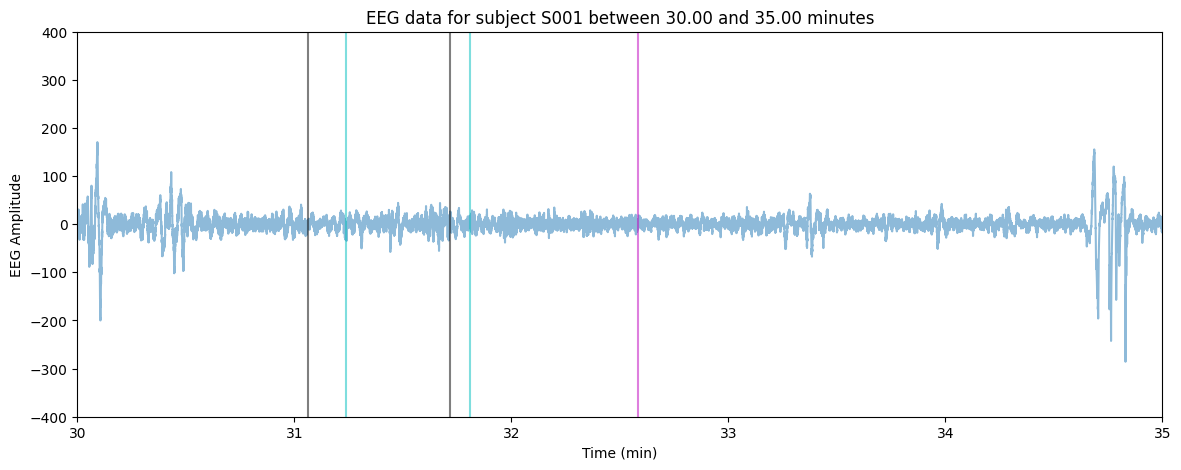

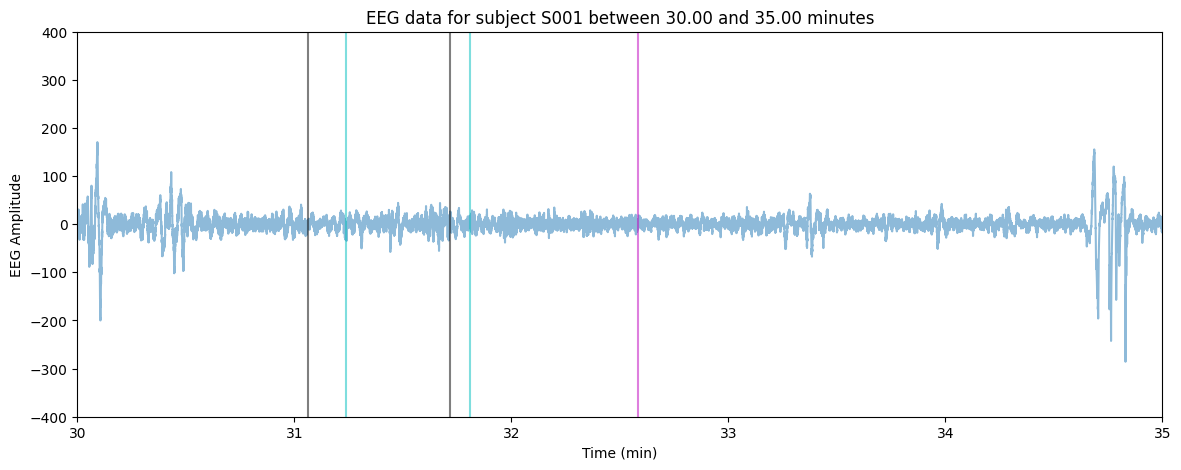

In [45]:
plot_eeg(eeg, SUBJECT, 30, 35, labels)[0]

Finally, we can create "epochs" around each event and then collect all epochs for a particular event to get an idea for what the EEG signal looks like on avarage around each event. Note that epochs are taken to be 30 seconds long and starting at the event onset. You can play around with the tmin and tmax parameters to see how the epochs change for the function below to see how the epochs change, but keep in mind that pre-processed data and evaluation data assume this length and onset.

Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 170 events and 7501 original time points ...
0 bad epochs dropped
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated


/Users/jantinebroek/Projects/kaggle/bci_eeg/utils.py:65: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events=events, tmin=tmin, tmax=tmax, baseline=None, preload=True)


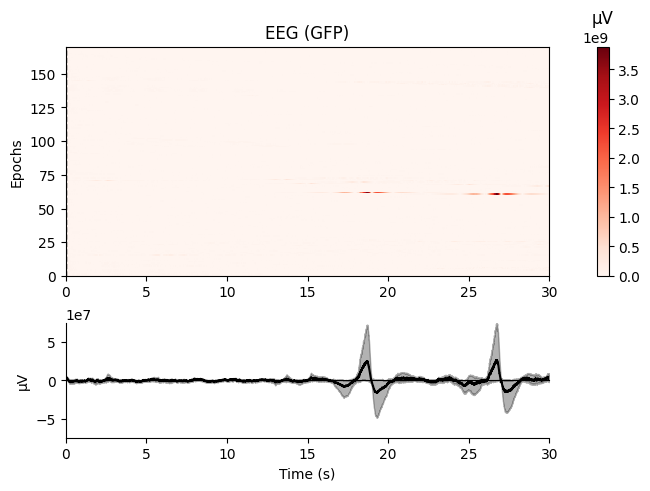

[<Figure size 640x480 with 3 Axes>]

In [46]:
epochs = get_event_epochs(eeg, labels, 'REM')
epochs.plot_image()

## Loading Pre-processed data

_X.npy and _Y.npy files contain the pre-processed data and labels, respectively. When loaded, they should be arrays of shape n_epochs x n_samples and n_epochs respectively. n_samples is 7501 (30 seconds of EEG at 250 Hz).The number of epochs changes across subjects, but the number of samples per epoch is fixed.

In [47]:
X = np.load(data_dir / f"{SUBJECT}_X.npy")
Y = np.load(data_dir / f"{SUBJECT}_Y.npy")

print(X.shape, Y.shape)

(655, 7501) (655,)


In [48]:
# The Y array contains the marker label associated with each epoch.
Y[:5]

array(['S', 'S', 'S', 'S', 'S'], dtype='<U4')

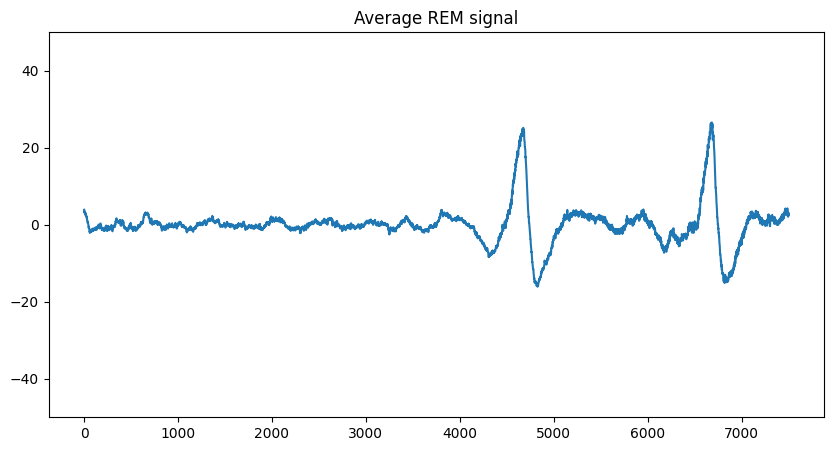

In [49]:
# To get the epochs associated to a particular event, we can simply index the Y array. The following plot should look similar to the one above.
idxs = np.where(Y == 'REM')[0]
rem_X = X[idxs]

rem_average = rem_X.mean(axis=0)

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(rem_average)
ax.set(title="Average REM signal", ylim=[-50, 50])
plt.show()

In [50]:
# As we can see, the number of epochs per event is different across events.
counts = {m: len(np.where(Y == m)[0]) for m in markers}
percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
summary = pd.DataFrame({'Count': counts, 'Percent': percents})
summary

,Count,Percent
S,210,32.06
K,199,30.38
REM,170,25.95
Son,29,4.43
Soff,18,2.75
A,22,3.36
MS,7,1.07


# Fitting Models

In this section we show how to fit a few simple models using scikit-learn and a more advanced deep learning model (time-series convolutional neural network) with PyTorch.

For simplicity, we will split the data from one subject into training and test sets. For the competition, however, you will have access to all the training data from three subjects and you will be asked to make predictions on data from a fourth subject for whom you do not have labels.

The code implementation will be similar, however, so you can use these examples to get started.

## Train-Test Split

In [51]:
# We need to "stratify" the split to ensure that the training and test sets have the same proportions of each event type as the whole dataset.

def print_class_proportions(Y, label:str):
    counts = {m: len(np.where(Y == m)[0]) for m in markers}
    percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
    summary = pd.DataFrame({'Count': counts, 'Percent': percents})
    # sort by count
    summary = summary.sort_values(by='Count', ascending=False)
    print(f"\n{label} dataset:")
    print(summary)


# counts for the whole dataset
print_class_proportions(Y, "Whole dataset")


Whole dataset dataset:
      Count  Percent
S       210    32.06
K       199    30.38
REM     170    25.95
Son      29     4.43
A        22     3.36
Soff     18     2.75
MS        7     1.07


In [52]:
def print_class_proportions(Y, label:str):
    counts = {m: len(np.where(Y == m)[0]) for m in markers}
    percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
    summary = pd.DataFrame({'Count': counts, 'Percent': percents})
    # sort by count
    summary = summary.sort_values(by='Count', ascending=False)
    print(f"\n{label} dataset:")
    print(summary)


# counts for the whole dataset
print_class_proportions(Y, "Whole dataset")


Whole dataset dataset:
      Count  Percent
S       210    32.06
K       199    30.38
REM     170    25.95
Son      29     4.43
A        22     3.36
Soff     18     2.75
MS        7     1.07


In [53]:
# the classess are not balanced, so we need to stratify the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
print_class_proportions(Y_train, "Training set")
print_class_proportions(Y_test, "Test set")


Training set dataset:
      Count  Percent
S       168    32.06
K       159    30.34
REM     136    25.95
Son      23     4.39
A        18     3.44
Soff     14     2.67
MS        6     1.15

Test set dataset:
      Count  Percent
S        42    32.06
K        40    30.53
REM      34    25.95
Son       6     4.58
Soff      4     3.05
A         4     3.05
MS        1     0.76


In [54]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We define a couple of helper functions to fit models and plot the confusion matrix.

Our main metric will be balanced F1 score which is ideal for imbalanced datasets, striking a balance between precision and recall. We also show balanced_accuracy_score. We also plot the confusion matrix to see how often each event type is predicted as another.

In [55]:
def plot_confusion_matrix(conf_mat, markers, title):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=markers, yticklabels=markers, ax=ax)

    # highlight the diagonal elements
    for i in range(conf_mat.shape[0]):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=1))

    ax.set(
           title=title,
           xlabel='Predicted',
           ylabel='True',
           aspect='equal'
           )
    plt.show()


def fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)

    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)

    if set(Y_pred_train) != set(Y_train):
        print(f"Predicted classes {set(Y_pred_train)} do not match true classes {set(Y_train)}")
    if set(Y_pred_test) != set(Y_test):
        print(f"Predicted classes {set(Y_pred_test)} do not match true classes {set(Y_test)}")

    train_acc = balanced_accuracy_score(Y_train, Y_pred_train)
    test_acc = balanced_accuracy_score(Y_test, Y_pred_test)
    print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

    train_f1 = f1_score(Y_train, Y_pred_train, average='weighted')
    test_f1 = f1_score(Y_test, Y_pred_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
    
    conf_mat = confusion_matrix(Y_test, Y_pred_test, normalize='true')
    title=f"{clf.__class__.__name__} - Train: {train_f1:.4f}, Test: {test_f1:.4f}"
    plot_confusion_matrix(conf_mat, markers, title)

/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Train accuracy: 1.0000, Test accuracy: 0.1971
Train F1: 1.0000, Test F1: 0.3208


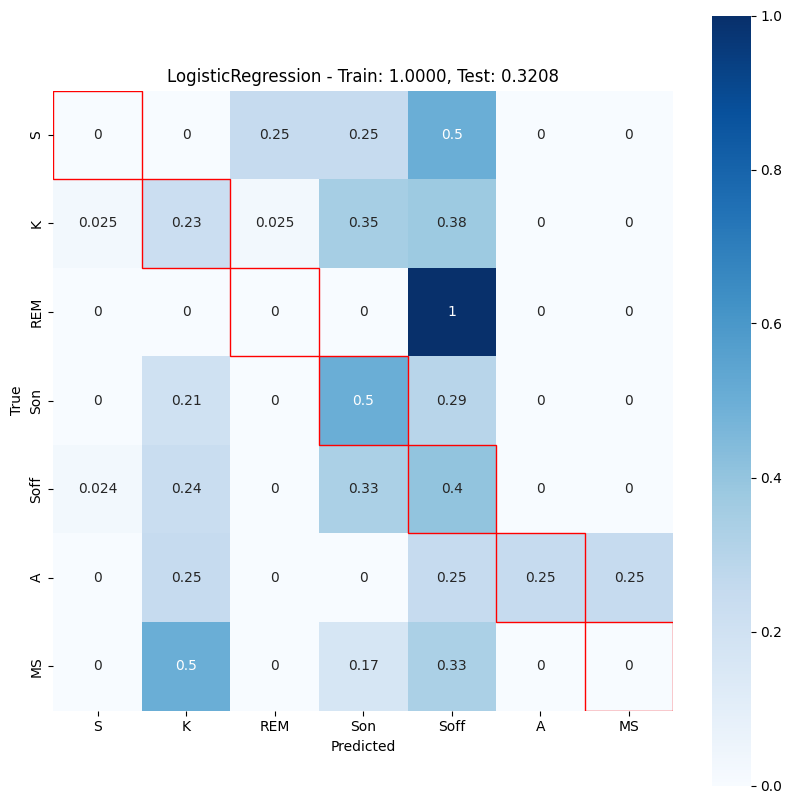

In [56]:
# fit multi-class logistic regression
clf = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000, class_weight=None)
fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test)

It seems to be predicting most data as K or REM. This is not surprising given that these are the most frequent event types.

In [57]:
print_class_proportions(Y, "Whole dataset")


Whole dataset dataset:
      Count  Percent
S       210    32.06
K       199    30.38
REM     170    25.95
Son      29     4.43
A        22     3.36
Soff     18     2.75
MS        7     1.07


We can use class_weight="balanced" to give more weight to less frequent classes. This should improve the performance of the model on the minority classes.

/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Train accuracy: 1.0000, Test accuracy: 0.2013
Train F1: 1.0000, Test F1: 0.3269


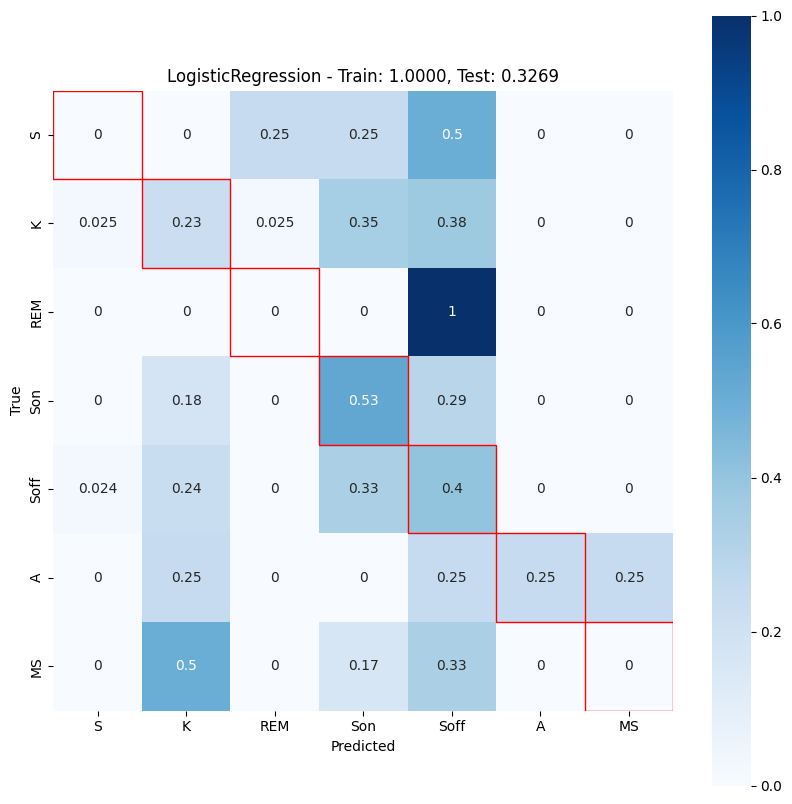

In [58]:
# fit multi-class logistic regression with class weights
clf = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000, class_weight="balanced")    
fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test)

This didn't improve too much, but maybe that's because logistic regression is just too simple of a model for this task. Let's try a couple more advanced models (SVM and random forest). Play around with class_weight to see how it affects the results.

Predicted classes {'Son', 'K', 'A', 'REM', 'S'} do not match true classes {'Son', 'K', 'Soff', 'A', 'REM', 'MS', 'S'}
Train accuracy: 0.4693, Test accuracy: 0.2410
Train F1: 0.2822, Test F1: 0.1348


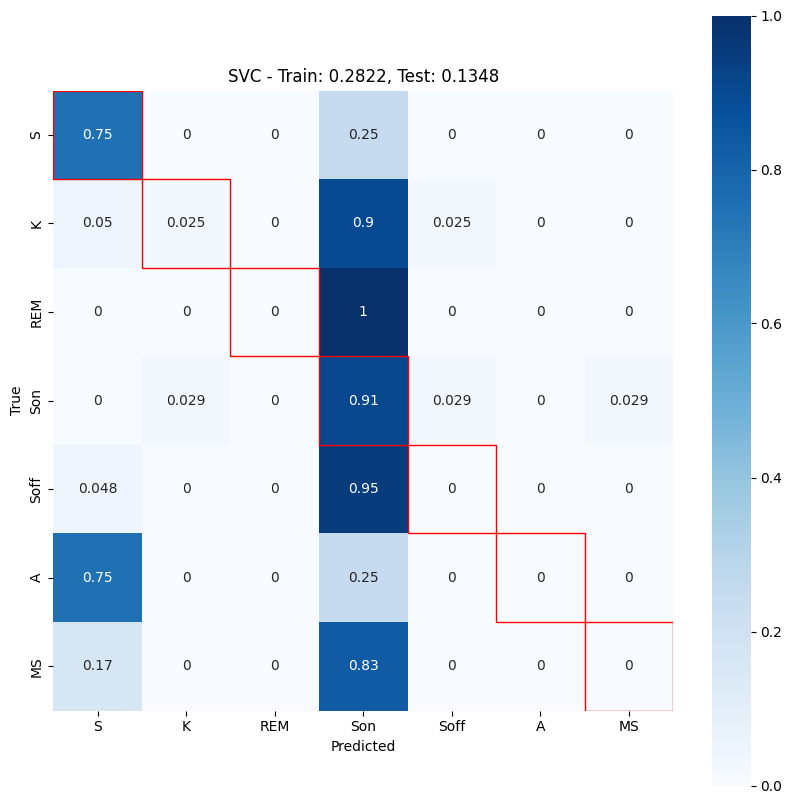

In [59]:
from sklearn.svm import SVC

svc_cls = SVC(kernel='rbf', random_state=42, class_weight="balanced")  # class_weight None or "balanced"
fit_and_eval_sk_classifier(svc_cls, X_train, Y_train, X_test, Y_test)

You can also define your own custom weights based on the class frequencies. The example below is a bad set of weights, but you can play around with weights to see how to get the right balance across classes.

Predicted classes {'REM', 'K', 'S'} do not match true classes {'Son', 'K', 'Soff', 'A', 'REM', 'MS', 'S'}
Train accuracy: 0.3986, Test accuracy: 0.1410
Train F1: 0.2894, Test F1: 0.1413


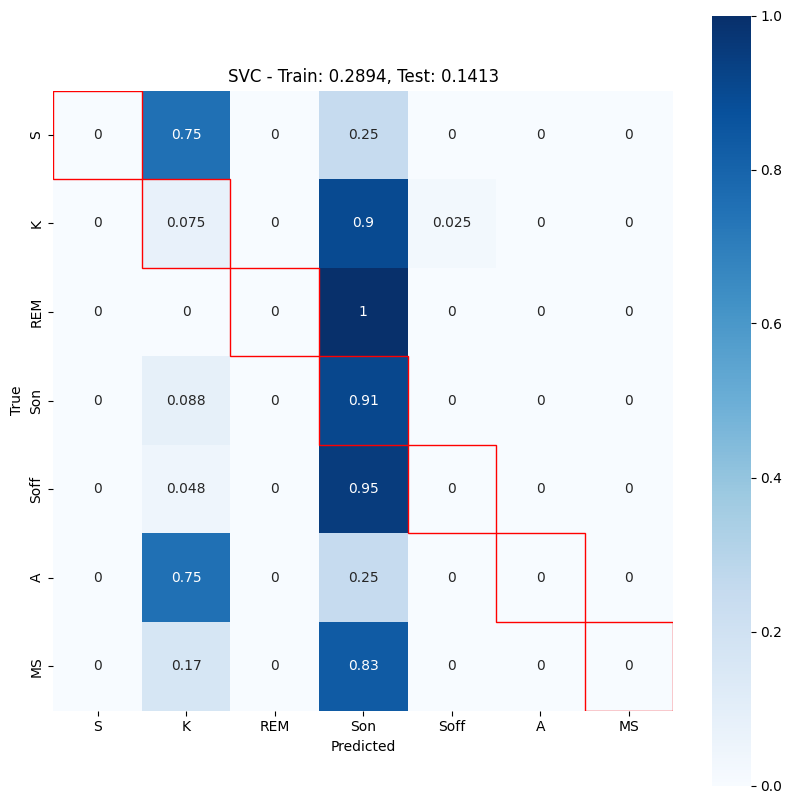

In [60]:
weights = {
    'S' : 1,
    'A': 1,
    'K': 1,
    'MS': 1,
    'REM': 10,
    'Son': 1,
    'Soff': 1,
}

svc_cls = SVC(kernel='rbf', random_state=42, class_weight=weights)  # pass  your own weights dictionary
fit_and_eval_sk_classifier(svc_cls, X_train, Y_train, X_test, Y_test)

Predicted classes {'Son', 'K', 'A', 'REM', 'MS', 'S'} do not match true classes {'Son', 'K', 'Soff', 'A', 'REM', 'MS', 'S'}
Train accuracy: 0.9024, Test accuracy: 0.1808
Train F1: 0.9424, Test F1: 0.2947


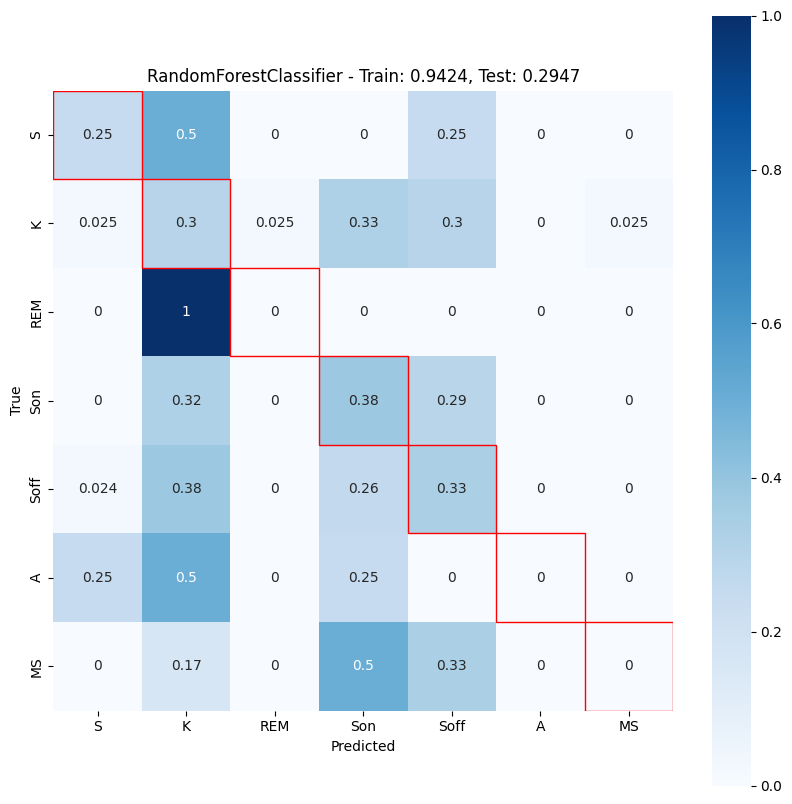

In [61]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_cls = RandomForestClassifier(n_estimators=5, random_state=42, class_weight="balanced")
fit_and_eval_sk_classifier(rf_cls, X_train, Y_train, X_test, Y_test)

# A deep learning model

Deep learning models are a natural choice for time-series classification tasks. We'll define a simple time-series convolutional neural network (tCNN) and train it using PyTorch.

We'll build on the lessons learned from the previous models to improve the performance of the deep learning model. We want something that is powerful enough to learn the complex relationships between EEG signals and the different event types, but we'll be careful to avoid overfitting. We'll apply three standard techniques to avoid overfitting:

    Augmentation: we'll create perturbed versions of the data to make the model more robust.
    Regularization: we'll add a penalty to the loss function to discourage complex models.
    Early stopping: we'll do a short training run (you might want to use the validation loss to stop training more precisely)

The following block defines the model architecture

In [62]:
# define a time convolutional feed forward neural network with pytoimport torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch

class TimeSeriesCNN(nn.Module):
    def __init__(self, input_length, num_classes=7):
        super(TimeSeriesCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of flattened features
        self.flatten_size = self._get_flatten_size(input_length)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def _get_flatten_size(self, input_length):
        # Helper function to calculate flattened size
        x = torch.randn(1, 1, input_length)
        x = self.conv_layers(x)
        return x.shape[1] * x.shape[2]
    
    def forward(self, x):
        # x shape: (batch_size, n_samples)
        # Add channel dimension
        x = x.unsqueeze(1)  # (batch_size, 1, n_samples)
        
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


In [63]:
# Next, we define a training function that will handle the augmentation, regularization, and early stopping for us.
# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda', lr=0.001, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights) 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # weight_decay is L2 regularization
        
    model = model.to(device)
    best_val_loss = np.inf
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model.state_dict()

        val_acc = 100. * correct / total
        
        if epoch == 0 or (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
            print('--------------------')

    return best_model


In [65]:
# Finally, we define some custom Datasets to handle the augmentation and data loading.
from torch.utils.data import Dataset

class TimeSeriesAugmentation:
    def __init__(self, noise_level=0.05, shift_range=10):
        self.noise_level = noise_level
        self.shift_range = shift_range
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_level
        return x + noise
    
    def time_shift(self, x):
        # Generate random shift value
        shift = torch.randint(-self.shift_range, self.shift_range, (1,)).item()
        # Roll the tensor along the time dimension
        return torch.roll(x, shifts=shift, dims=0)
    
    def scale(self, x):
        scale_factor = torch.rand(1) * 0.4 + 0.8  # Random scale between 0.8 and 1.2
        return x * scale_factor

class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment
        self.aug = TimeSeriesAugmentation()
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()  # Create a copy to avoid modifying original data
        if self.augment:
            if torch.rand(1) < 0.5:
                x = self.aug.add_noise(x)
            if torch.rand(1) < 0.5:
                x = self.aug.time_shift(x)
            if torch.rand(1) < 0.5:
                x = self.aug.scale(x)
        return x, self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [66]:
# Training the DL model
# We need to convert the labels to integers and then to PyTorch tensors and turn the data into PyTorch tensors. Then we prepare dataloaders using our custom datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# convert Y from text labels to integer labels
_markers = list(set(Y))
_Y_train = [_markers.index(m) for m in Y_train]
_Y_test = [_markers.index(m) for m in Y_test]

# Convert to PyTorch tensors
_X_train = torch.FloatTensor(X_train)
_Y_train = torch.LongTensor(_Y_train)
_X_test = torch.FloatTensor(X_test)
_Y_test = torch.LongTensor(_Y_test)

# Create data loaders
train_dataset = AugmentedDataset(_X_train, _Y_train)
val_dataset = AugmentedDataset(_X_test, _Y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [67]:
# Train
# Initialize model
input_length = X_train.shape[1]  # number of time samples
model = TimeSeriesCNN(input_length=input_length, num_classes=len(set(Y)))

model = model.to(device)

# Train model
best_model = train_model(model, train_loader, val_loader, num_epochs=30, device=device, lr=1e-4)

/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/30]
Train Loss: 1.6263, Train Acc: 30.15%
Val Loss: 1.4418, Val Acc: 32.06%
--------------------
Epoch [5/30]
Train Loss: 1.2598, Train Acc: 47.90%
Val Loss: 1.3528, Val Acc: 34.35%
--------------------
Epoch [10/30]
Train Loss: 1.0020, Train Acc: 60.11%
Val Loss: 1.4143, Val Acc: 44.27%
--------------------
Epoch [15/30]
Train Loss: 0.8255, Train Acc: 70.61%
Val Loss: 1.7200, Val Acc: 35.88%
--------------------
Epoch [20/30]
Train Loss: 0.5966, Train Acc: 80.53%
Val Loss: 1.6938, Val Acc: 37.40%
--------------------
Epoch [25/30]
Train Loss: 0.4742, Train Acc: 85.11%
Val Loss: 2.3069, Val Acc: 43.51%
--------------------
Epoch [30/30]
Train Loss: 0.3243, Train Acc: 90.46%
Val Loss: 2.5732, Val Acc: 42.75%
--------------------


To evaluate the model, we can load the best model and compute the balanced accuracy and F1 score. We also plot the confusion matrix to see how often each event type is predicted as another.

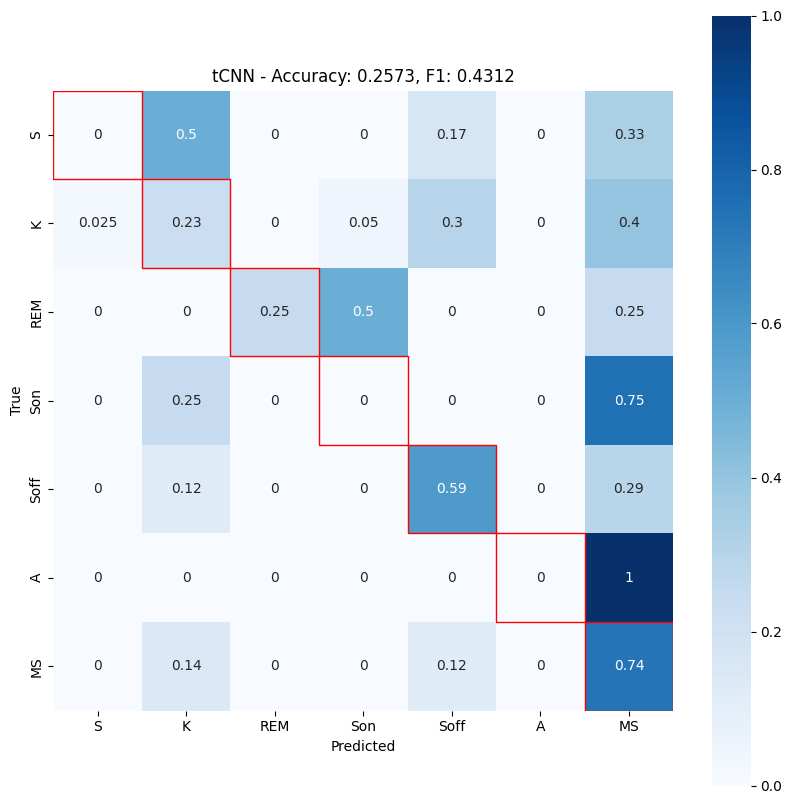

In [68]:
# load best model
model.load_state_dict(best_model)

# compute metric
Y_pred = model(_X_test.to(device)).argmax(1).cpu().numpy()
score = balanced_accuracy_score(_Y_test, Y_pred)
f1 = f1_score(_Y_test, Y_pred, average='weighted')

# plot confusion matrix
conf_mat = confusion_matrix(_Y_test, Y_pred, normalize='true')
plot_confusion_matrix(conf_mat, markers, f"tCNN - Accuracy: {score:.4f}, F1: {f1:.4f}")

Similarly to what we did for the previous models, we can balance the classes by computing the class weights based on the frequency of each class in the training set. Here we compute the weights of each class in the training set and pass them to the CrossEntropyLoss function.

Epoch [1/30]
Train Loss: 0.4781, Train Acc: 88.36%
Val Loss: 6.2744, Val Acc: 49.62%
--------------------
Epoch [5/30]
Train Loss: 0.5538, Train Acc: 91.60%
Val Loss: 5.4459, Val Acc: 46.56%
--------------------
Epoch [10/30]
Train Loss: 0.2235, Train Acc: 94.08%
Val Loss: 4.4288, Val Acc: 49.62%
--------------------
Epoch [15/30]
Train Loss: 0.2162, Train Acc: 94.08%
Val Loss: 4.6676, Val Acc: 51.15%
--------------------
Epoch [20/30]
Train Loss: 0.2823, Train Acc: 94.27%
Val Loss: 4.0774, Val Acc: 53.44%
--------------------
Epoch [25/30]
Train Loss: 0.1016, Train Acc: 97.90%
Val Loss: 4.2920, Val Acc: 48.85%
--------------------
Epoch [30/30]
Train Loss: 0.0687, Train Acc: 98.09%
Val Loss: 5.2442, Val Acc: 51.91%
--------------------


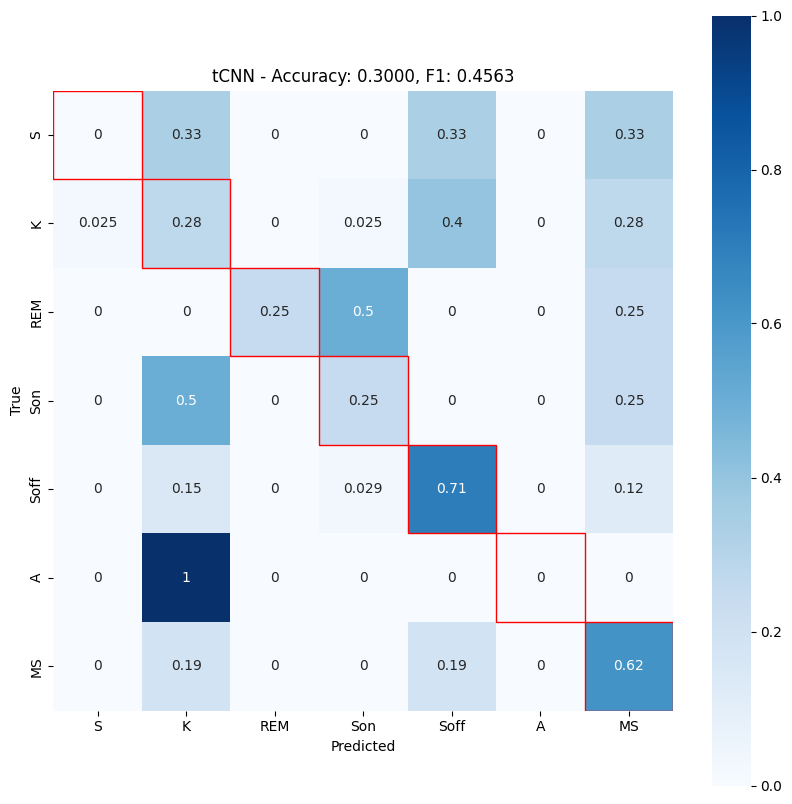

In [69]:
# Calculate class weights based on frequency
def compute_class_weights(y_train):
    class_counts = torch.bincount(y_train)
    total = len(y_train)
    weights = total / (len(class_counts) * class_counts.float())
    return weights


weights = compute_class_weights(_Y_train).to(device)
balanced_model = train_model(model, train_loader, val_loader, num_epochs=30, device=device, lr=1e-4, class_weights=weights)

# load best model
model.load_state_dict(best_model)

# compute metric
Y_pred = model(_X_test.to(device)).argmax(1).cpu().numpy()
score = balanced_accuracy_score(_Y_test, Y_pred)
f1 = f1_score(_Y_test, Y_pred, average='weighted')

# plot confusion matrix
conf_mat = confusion_matrix(_Y_test, Y_pred, normalize='true')
plot_confusion_matrix(conf_mat, markers, f"tCNN - Accuracy: {score:.4f}, F1: {f1:.4f}")

# Prepare Submission File


In [70]:
Y_test_pred = clf.predict(X_test)
print(Y_test_pred[:5])

IDs = np.arange(len(Y_test_pred))

df = pd.DataFrame({"ID":IDs, "Marker": Y_test_pred})
df.head()
df.to_csv("example_submission.csv", index=False)

['REM' 'S' 'K' 'S' 'K']
